In [240]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import cv2
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

<IPython.core.display.Javascript object>


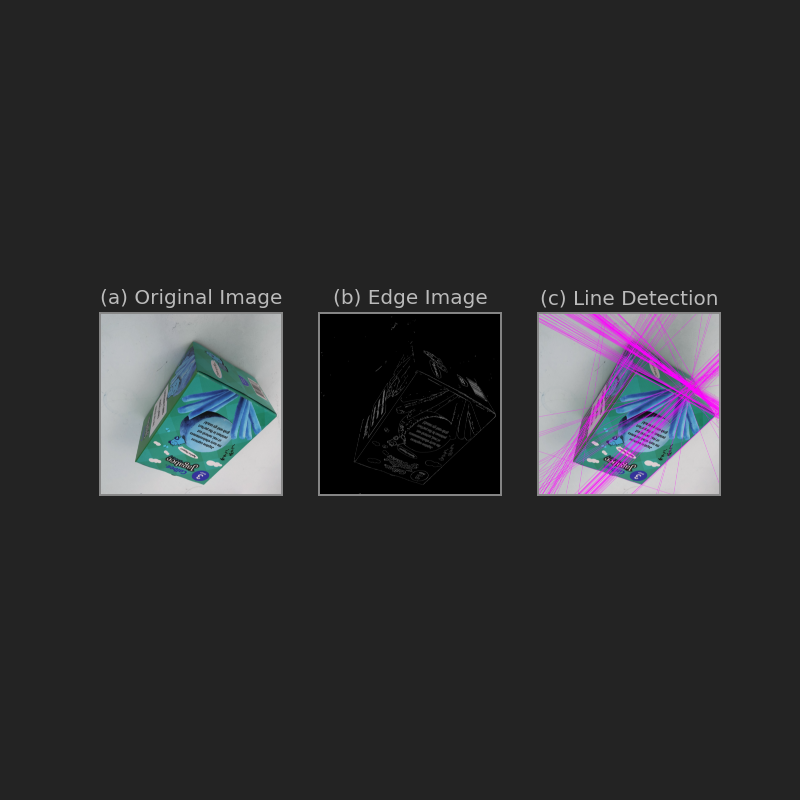

In [248]:
path = "dataset/snack1.jpg"
img = cv2.imread(path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
im = cv2.filter2D(gray, -1, kernel)

fig = plt.figure()

# cv2.Canny( detected_edges, detected_edges, lowThreshold, lowThreshold*ratio, kernel_size);
edges = cv2.Canny(gray,50,150,apertureSize = 3)
ax = plt.subplot(131)
ax.imshow(img,cmap = 'gray')
plt.title('(a) Original Image'), plt.xticks([]), plt.yticks([])

ax = plt.subplot(132)
ax.imshow(edges,cmap = 'gray')
plt.title('(b) Edge Image'), plt.xticks([]), plt.yticks([])

lines = cv2.HoughLines(edges,1,np.pi/180,200)
for line in lines:
  for rho,theta in line:
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a*rho
      y0 = b*rho
      x1 = int(x0 + 5000*(-b))
      y1 = int(y0 + 5000*(a))
      x2 = int(x0 - 5000*(-b))
      y2 = int(y0 - 5000*(a))
      cv2.line(img,(x1,y1),(x2,y2),(255,0,255),2)
#img = img[:256,:192]
ax = plt.subplot(133)
ax.imshow(img,cmap = 'gray')
plt.title('(c) Line Detection'), plt.xticks([]), plt.yticks([])
fig.savefig('edge.png')

In [183]:
# CS231A Homework 1, Problem 3
import numpy as np
#from utils import mat2euler
import math

'''
COMPUTE_VANISHING_POINTS
Arguments:
    points - a list of all the points where each row is (x, y). Generally,
            it will contain four points: two for each parallel line.
            You can use any convention you'd like, but our solution uses the
            first two rows as points on the same line and the last
            two rows as points on the same line.
Returns:
    vanishing_point - the pixel location of the vanishing point
'''
def compute_vanishing_point(points):
    # BEGIN YOUR CODE HERE
    x0 = points[0:1].T
    d0 = (points[1:2] - points[0:1]).T
    x1 = points[2:3].T
    d1 = (points[3:4] - points[2:3]).T
    A = np.concatenate((d0, -d1), axis = 1)
    b = x1 - x0
    # solve Av = b
    Ainv = np.linalg.pinv(A)
    v = Ainv.dot(b)
    s0 = v[0,0]
    s1 = v[1,0]
    return (x0 + s0*d0).flatten()
    # END YOUR CODE HERE

'''
COMPUTE_K_FROM_VANISHING_POINTS
Arguments:
    vanishing_points - a list of vanishing points

Returns:
    K - the intrinsic camera matrix (3x3 matrix)
'''
def compute_K_from_vanishing_points(vanishing_points):
    # BEGIN YOUR CODE HERE
    def helper(a, b):
      return [a[0]*b[0]+a[1]*b[1], a[0]+b[0], a[1]+b[1]]
    v1 = vanishing_points[0]
    v2 = vanishing_points[1]
    v3 = vanishing_points[2]
    A = []
    A.append(helper(v1, v2))
    A.append(helper(v1, v3))
    A.append(helper(v2, v3))
    A = np.array(A)
    negI = -np.ones((3, 1))
    #solve Ab = -I
    Ainv = np.linalg.pinv(A)
    w = Ainv.dot(negI)
    W = np.array([[w[0,0], 0, w[1,0]], [0, w[0,0], w[2,0]], [w[1,0], w[2,0], 1]])
    L = np.linalg.cholesky(W).T
    Linv = np.linalg.pinv(L)
    Linv /= Linv[2,2]
    return Linv
    # END YOUR CODE HERE

'''
COMPUTE_ANGLE_BETWEEN_PLANES
Arguments:
    vanishing_pair1 - a list of a pair of vanishing points computed from lines within the same plane
    vanishing_pair2 - a list of another pair of vanishing points from a different plane than vanishing_pair1
    K - the camera matrix used to take both images

Returns:
    angle - the angle in degrees between the planes which the vanishing point pair comes from2
'''
def compute_angle_between_planes(vanishing_pair1, vanishing_pair2, K):
    # BEGIN YOUR CODE HERE
    Kinv = np.linalg.pinv(K)
    v1 = np.concatenate((vanishing_pair1[0], np.ones(1)), axis = 0)
    v2 = np.concatenate((vanishing_pair1[1], np.ones(1)), axis = 0)
    da1 = Kinv.dot(v1)
    da2 = Kinv.dot(v2)
    na = np.cross(da1.flatten(), da2.flatten())
    na /= (na.dot(na))**0.5

    u1 = np.concatenate((vanishing_pair2[0], np.ones(1)), axis = 0)
    u2 = np.concatenate((vanishing_pair2[1], np.ones(1)), axis = 0)
    db1 = Kinv.dot(u1)
    db2 = Kinv.dot(u2)
    nb = np.cross(db1.flatten(), db2.flatten())
    nb /= (nb.dot(nb))**0.5
    angle = math.acos(nb.dot(na)) / math.pi * 180
    return angle
    # END YOUR CODE HERE

'''
COMPUTE_ROTATION_MATRIX_BETWEEN_CAMERAS
Arguments:
    vanishing_points1 - a list of vanishing points in image 1
    vanishing_points2 - a list of vanishing points in image 2
    K - the camera matrix used to take both images

Returns:
    R - the rotation matrix between camera 1 and camera 2
'''
def compute_rotation_matrix_between_cameras(vanishing_points1, vanishing_points2, K):
    # BEGIN YOUR CODE HERE
    Kinv = np.linalg.pinv(K)
    d1_ls = []
    for v in vanishing_points1:
      v_ = np.concatenate((v, np.ones(1)), axis = 0)
      d = Kinv.dot(v_)
      d1_ls.append(d / np.linalg.norm(d))
    d1_ls = np.array(d1_ls)

    d2_ls = []
    for v in vanishing_points2:
      v_ = np.concatenate((v, np.ones(1)), axis = 0)
      d = Kinv.dot(v_)
      d2_ls.append(d / np.linalg.norm(d))
    d2_ls = np.array(d2_ls)

    R = np.linalg.lstsq(d1_ls, d2_ls, rcond=None)[0]
    R = R.T
    return R
    # END YOUR CODE HERE


In [184]:
import json
import os
from mpl_toolkits import mplot3d


In [280]:
class Box():
  def __init__(self, filename):
    fp = open(filename)
    json_obj = json.loads(fp.read())
    plane_ls = []
    corner_ls = []
    parallel_line_pair_ls = []
    for shape in json_obj['shapes']:
      label = shape['label']
      if label == 'plane':
          plane_ls.append(shape['points'])
      if label == 'corner':
          corner_ls.extend(shape['points'])
    for plane in plane_ls:
      parallel_line_pair_ls.append([plane[0],plane[1],plane[2],plane[3]])
      parallel_line_pair_ls.append([plane[1],plane[2],plane[3],plane[0]])
    self.plane_ls = np.array(plane_ls)
    self.corner_ls = np.array(corner_ls)
    self.parallel_line_pair_ls = np.array(parallel_line_pair_ls)
    self.image_path = os.path.join("dataset", json_obj["imagePath"])
    self.image = cv2.imread(self.image_path)
    
  def augment(self):
    fig,ax = plt.subplots(1)
    self.aug_img = self.image[:,:,:]
    ax.imshow(self.aug_img)
    for plane in self.plane_ls:
      num = len(plane)
      for idx in range(num):
        x1 = plane[idx,0]
        y1 = plane[idx,1]
        x2 = plane[(idx + 1)%num,0]
        y2 = plane[(idx + 1)%num,1]
        ax.plot([x1,x2], [y1,y2], linewidth=4)
        
    for corner in self.corner_ls:
      circ = Circle(corner,50,color='r')
      ax.add_patch(circ)
    fig.savefig('augment.png')
    
  def get_vanishing_points(self):
    self.vanishing_points = []
    for points in self.parallel_line_pair_ls:
      vpoint = compute_vanishing_point(points)
      self.vanishing_points.append(vpoint)
        
  def show_vanishing_points(self):
    fig,ax = plt.subplots(1)
    ax.imshow(self.image)
    min_x = 0
    min_y = 0
    max_x = self.image.shape[1]
    max_y = self.image.shape[0]
    for points in self.parallel_line_pair_ls[0:3]:
      vpoint = compute_vanishing_point(points)
      x0 = list(points[0:2,0]) + [vpoint[0]]
      y0 = list(points[0:2,1]) + [vpoint[1]]
      ax.plot(x0, y0)
    
      min_x  = min(min(x0), min_x)
      max_x  = max(max(x0), max_x)
      min_y  = min(min(y0), min_y)
      max_y  = max(max(y0), max_y)
    
      x1 = list(points[2:5,0]) + [vpoint[0]]
      y1 = list(points[2:4,1]) + [vpoint[1]]
      ax.plot(x1, y1)
        
      min_x  = min(min(x1), min_x)
      max_x  = max(max(x1), max_x)
      min_y  = min(min(y1), min_y)
      max_y  = max(max(y1), max_y)
        
      circ = Circle(vpoint,50,color='r')
      ax.add_patch(circ)
    plt.ylim([min_y, max_y])
    plt.xlim([min_x, max_x])
    plt.show()
    fig.savefig('vanishing.png')
  def get_camera_matrix(self):
    self.get_vanishing_points()
    self.K = compute_K_from_vanishing_points(self.vanishing_points)
    
  def solve_plane_3d_position(self, K, plane, idx):
    K_inv = np.linalg.inv(K)
    p3d_ls = []
    for point in plane:
      p = [point[0], point[1], 1]
      p3d = K_inv.dot(p)
      p3d_ls.append(p3d)
    a = p3d_ls[(idx + 1)%4]
    b = p3d_ls[(idx + 2)%4]
    c = p3d_ls[(idx + 3)%4]
    d = p3d_ls[idx]
    A = np.array([a,-b,c]).T
    A_inv = np.linalg.inv(A)
    r = A_inv.dot(d)
    scale_p3d_ls = [a * r[0], b * r[1], c * r[2], d]
    return scale_p3d_ls

  def assign_plane_corner_indices(self):
    self.plane_corner_indices = []
    cnt = [0, 0, 0, 0, 0, 0, 0]
    for plane in self.plane_ls:
      corner_idx = []
      for point in plane:
        best_idx = 0
        best_cost = -1
        for idx, corner in enumerate(self.corner_ls):
          diff = point - corner
          cost = abs(diff[0]) + abs(diff[1])
          if best_cost == -1:
            best_idx = idx
            best_cost = cost
          elif cost < best_cost:
            best_idx = idx
            best_cost = cost
        corner_idx.append(best_idx)
        cnt[best_idx] += 1
      self.plane_corner_indices.append(corner_idx)
    
      best_cnt = cnt[0]
      best_idx = 0
      for idx, c in enumerate(cnt):
        if c > best_cnt:
            best_cnt = c
            best_idx = idx
      self.share_corner_idx = best_idx
    
  def show_3d_reconstruction(self):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    for plane_idx, plane in enumerate(self.plane_ls):
      p3d_ls = []
      idx = 0
      for order, corner_idx in enumerate(self.plane_corner_indices[plane_idx]):
        if corner_idx == self.share_corner_idx:
          idx = order
      p3d_ls = self.solve_plane_3d_position(self.K, plane, idx)
      p3d_ls.append(p3d_ls[0])
      x = []
      y = []
      z = []
      for p3d in p3d_ls:
        x.append(p3d[0])
        y.append(p3d[1])
        z.append(p3d[2])
      ax.plot3D(x, y, z, 'blue') 
    ax.view_init(None, 100)
    fig.savefig('3drecon.png')


<IPython.core.display.Javascript object>


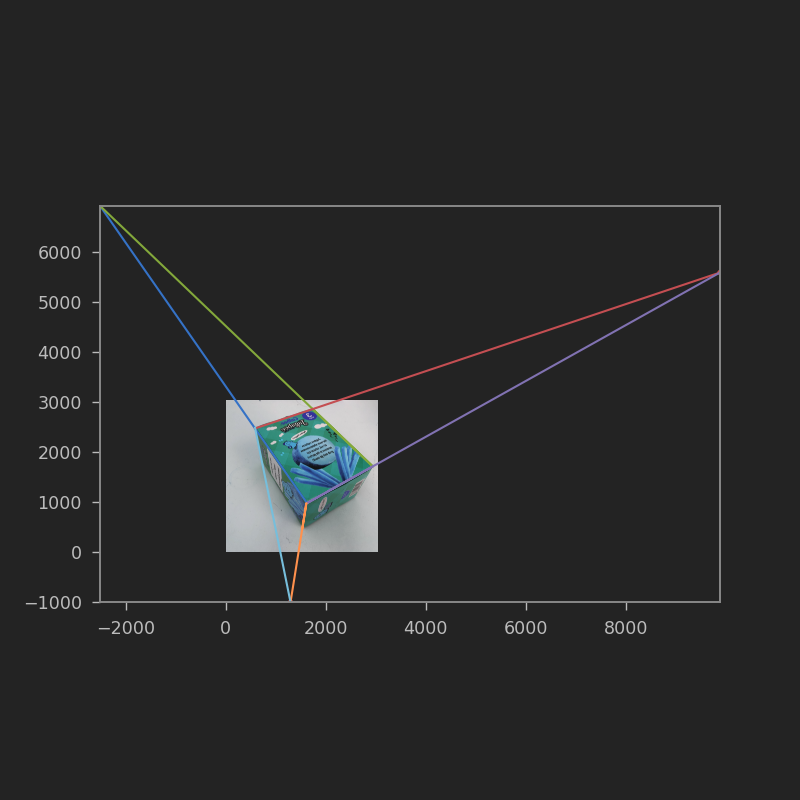

In [281]:
filename = "dataset/snack1.json"
box = Box(filename)
box.show_vanishing_points()

<IPython.core.display.Javascript object>


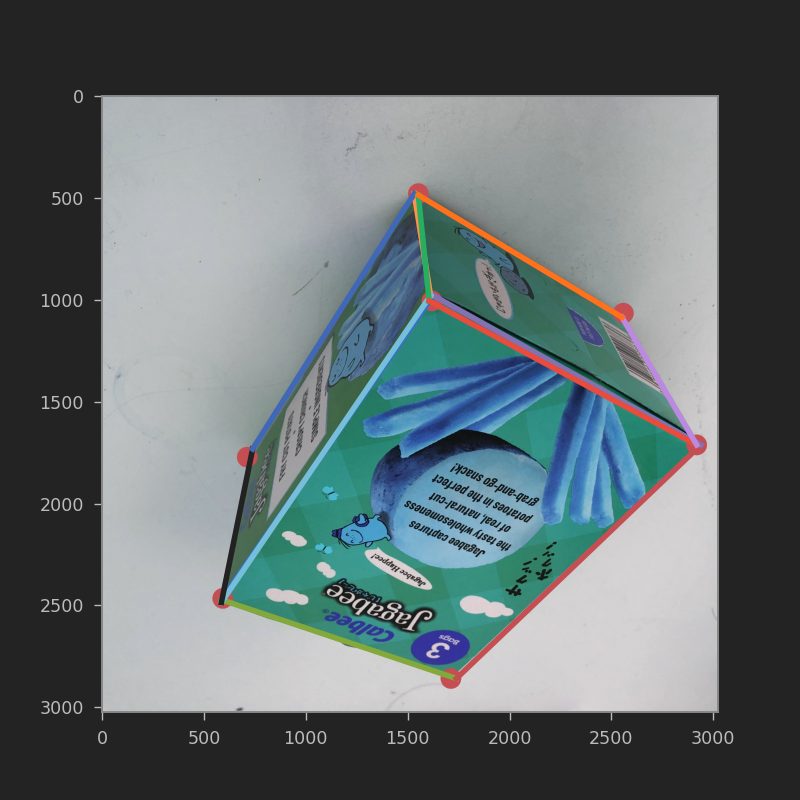

In [282]:
box.augment()

In [283]:
box.get_camera_matrix()
box.assign_plane_corner_indices()

<IPython.core.display.Javascript object>


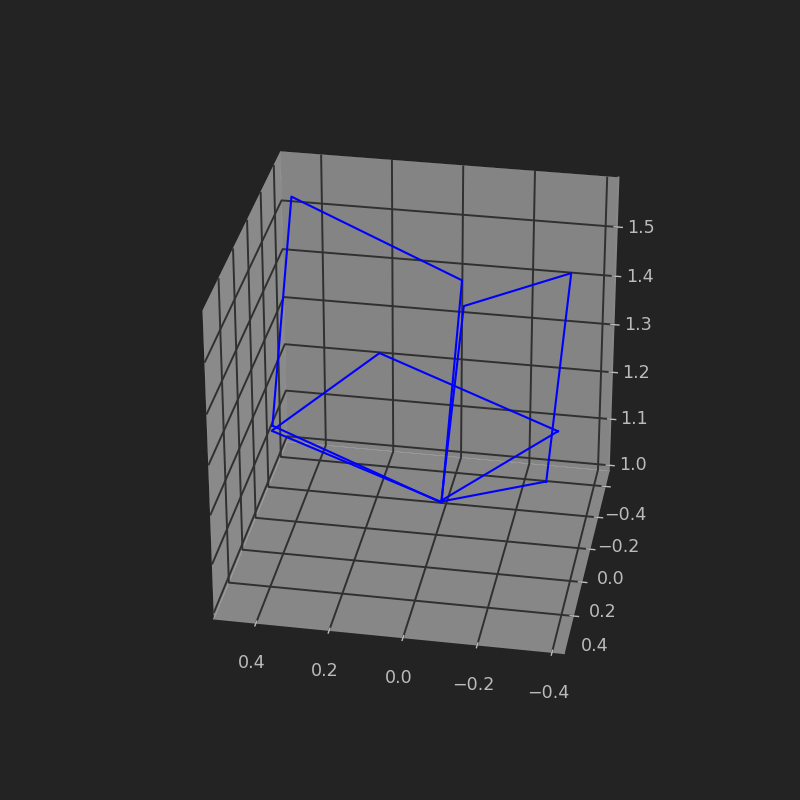

In [284]:
box.show_3d_reconstruction()